### Install and import required packages.

In [1]:
# pip install selenium

In [2]:
# pip install beautifulsoup4

In [3]:
# pip install webdriver-manager

In [4]:
# pip install wordcloud

In [5]:
from time import sleep
from bs4 import BeautifulSoup

from matplotlib import pyplot

from nltk.probability import FreqDist
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as ExpectedConditions
from selenium.webdriver.support.ui import WebDriverWait

from webdriver_manager.chrome import ChromeDriverManager

from wordcloud import WordCloud

### Create an instance of chrome browser (version 99+) in 'incognito' mode.

In [6]:
# Install and create an chrome service instance
chrome_service = ChromeService(ChromeDriverManager().install())

# Create an web driver instance with relavent options
chrome_options = ChromeOptions()
chrome_options.add_argument("--incognito")
# chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-notifications")
chrome_options.add_argument("--lang=en")

# Create session using web driver
chrome_driver = webdriver.Chrome(service=chrome_service, options=chrome_options)



====== WebDriver manager ======
Could not get version for google-chrome with the command:  powershell "$ErrorActionPreference='silentlycontinue' ; (Get-Item -Path "$env:PROGRAMFILES\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion ; if (-not $? -or $? -match $error) { (Get-Item -Path "$env:PROGRAMFILES(x86)\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion } if (-not $? -or $? -match $error) { (Get-Item -Path "$env:LOCALAPPDATA\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion } if (-not $? -or $? -match $error) { reg query "HKCU\SOFTWARE\Google\Chrome\BLBeacon" /v version } if (-not $? -or $? -match $error) { reg query "HKLM\SOFTWARE\Wow6432Node\Microsoft\Windows\CurrentVersion\Uninstall\Google Chrome" /v version }"
Current google-chrome version is UNKNOWN
Get LATEST chromedriver version for UNKNOWN google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/99.0.4844.51/chromedriver_win32.zip
Driver has been s

### Naivgate to requied URL. Accept consent form if required.

In [7]:

url = "https://www.google.com/maps/place/University+College+Dublin/@53.3064642,-6.2276766,17z/data=!3m1!4b1!4m5!3m4!1s0x4867093120c83a63:0x36762af31424bfcf!8m2!3d53.3064642!4d-6.2254879"
chrome_driver.get(url)

consent_selector = "//button[@aria-label='Agree to the use of cookies and other data for the purposes described']"
consent_agree_button = chrome_driver.find_element(by=By.XPATH, value=consent_selector);
consent_agree_button.click()

### Navigate to 'review' section and extract required information.

In [8]:
wait = WebDriverWait(chrome_driver, 30)
thread_sleep_time_in_secs = 5
scroll_for_x_mins = 1

# Open sort review menu
sort_review_menu_selector = "//button[@aria-label='Sort reviews']"
sort_review_menu_element = wait.until(ExpectedConditions.element_to_be_clickable((By.XPATH, sort_review_menu_selector)))
sort_review_menu_element.click()

sleep(thread_sleep_time_in_secs)

# Sort by newest reviews
newest_review_selector = "//li[@role='menuitemradio']"
newest_review_element = chrome_driver.find_elements(by=By.XPATH, value=newest_review_selector)[1]
newest_review_element.click()

sleep(thread_sleep_time_in_secs)

# Scroll down page and load as many review as it can in next X mins
scrollable_div = chrome_driver.find_element(by=By.CSS_SELECTOR, value='div.section-scrollbox')
for i in range(12 * scroll_for_x_mins):
    chrome_driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)
    sleep(thread_sleep_time_in_secs)
    
# Make sure all reviews are loaded completely
more_text_selector = "//button[@aria-label=' See more ']"
more_text_elements = chrome_driver.find_elements(by=By.XPATH, value=more_text_selector)
for element in more_text_elements:
    element.click()
    
sleep(thread_sleep_time_in_secs)

# Extract required infomation based on CSS selectors
response = BeautifulSoup(chrome_driver.page_source, 'html.parser')
reviews = response.select('span[class="ODSEW-ShBeI-text"]')
reviews = [review.get_text() for review in reviews]

# Terminate session using web driver
chrome_driver.quit()

### Process text and build corpus.

In [9]:
corpus = [review for review in reviews if review != ""]
corpus = ' '.join(corpus)

print(corpus)

Big campus great bus connections It is a good place for work but the payment is not good Not as good as trinity but it's alright Best place... It is one of the largest campuses I’ve ever been to. The lecturers are very helpful. There is always support for students whenever required: from stress management, time management, writing, financial and all. They also give away lots and lots of scholarships. It’s a home away from home. Truly a sanctuary school. I am proud to have attained my MSc here. Amazing Memory Lane. I was here from 1980-86 (Science). Wandered around location of old Belfield Bar (footprint part of large pond now!) & 'new' bar that replaced it, (sad looking one story concrete building in these pics). All's changed, changed utterly! (Translated by Google) Undoubtedly one of the most beautiful universities in Ireland, if you come to talk to me, give it a like... If not. I'll wait for you on instagram Inglesireland 😂

(Original)
Sin duda una de las Universidades más bellas de

### Analyse corpus.

In [10]:
processed_corpus = corpus.lower()

processed_corpus = word_tokenize(processed_corpus)

nltk_words = set(words.words())
processed_corpus = [word for word in processed_corpus if word in nltk_words]

processed_corpus = [word for word in processed_corpus if word not in stopwords.words('english')]
processed_corpus = [word for word in processed_corpus if len(word) > 0]
processed_corpus = [WordNetLemmatizer().lemmatize(word) for word in processed_corpus]

final_corpus = ' '.join(processed_corpus)

### Export corpus and analysis.

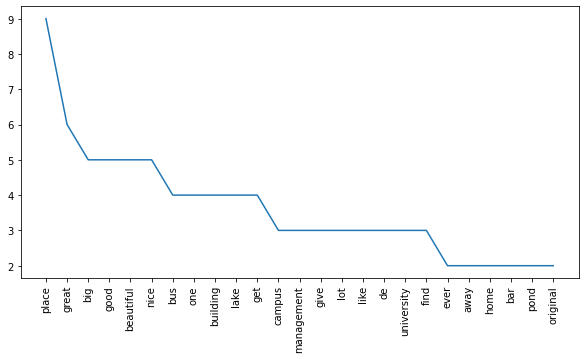

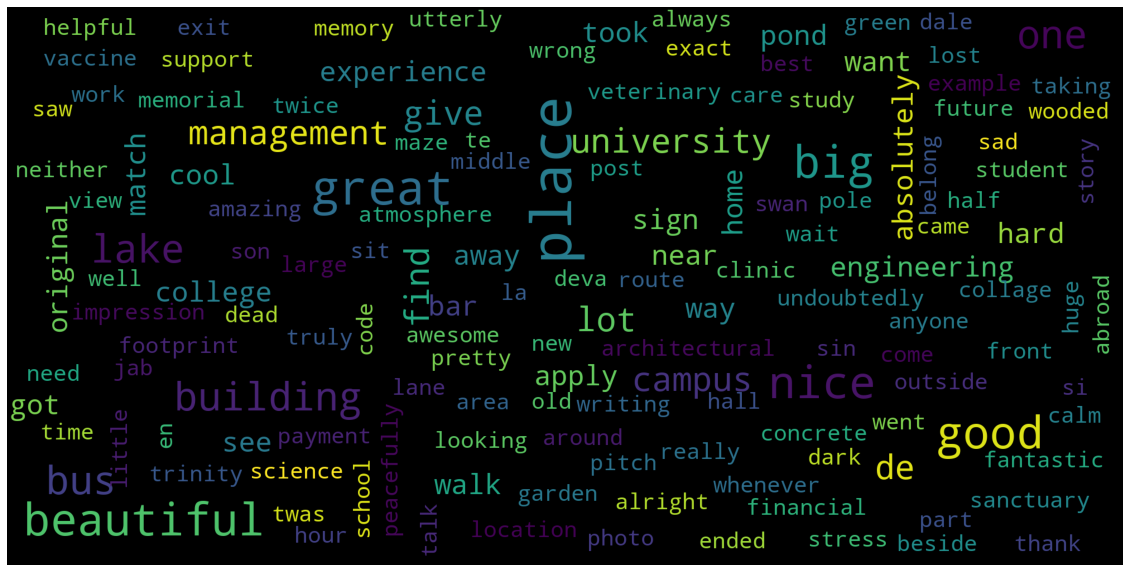

In [11]:
# Export corpus text
with open('corpus.txt', 'w') as corpus_file:
    corpus_file.write(final_corpus)

# Export frequency distribution
token_freq_dist = FreqDist(processed_corpus).most_common(25)
token_freq_dist_zip = list(zip(*token_freq_dist))

pyplot.figure(1, figsize = (10, 5))
pyplot.xticks(rotation=90)
pyplot.plot(list(token_freq_dist_zip[0]), list(token_freq_dist_zip[1]))
pyplot.savefig('token_freq_dist.png')
pyplot.show()


# Export word cloud
word_cloud = WordCloud(
    max_font_size = 20, 
    scale = 5
)

word_cloud.generate(final_corpus)

pyplot.figure(2, figsize = (20, 20))
pyplot.axis('off')
pyplot.imshow(word_cloud)
pyplot.savefig('word_cloud.png')
pyplot.show()